In [60]:
%pylab inline
from sklearn.neural_network import MLPRegressor
import bilby
import redback
import pandas as pd
from bilby.core.prior import Constraint, PriorDict, Uniform
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib.pyplot as plt
from redback.transient_models.afterglow_models import tophat
from sklearn import preprocessing as pre
import scipy.constants as const

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [94]:
def line(x, m, c, **kwargs):
    return m*x+c

prior = bilby.core.prior.PriorDict()
prior['m'] = bilby.core.prior.Uniform(3, 8, 'm')
prior['c'] = bilby.core.prior.Uniform(-2, 2, 'c')

In [95]:
xs = np.linspace(1, 20, 50)
models = 100
ys = np.zeros((models, len(xs)))
samples = pd.DataFrame(prior.sample(models))

In [96]:
for ii in range(models):
    ys[ii] = line(xs, **samples.iloc[ii].to_dict())
    plt.plot(xs, ys[ii], color='red', alpha=0.05)

In [97]:
X_train = samples.values
y_train = ys
regr = MLPRegressor(random_state=1, max_iter=5000).fit(X_train, y_train)

In [49]:
y_pred = regr.predict(np.array([4, -1]).reshape(1, -1))
print(y_pred.shape)

(1, 50)


In [48]:
y_true = line(xs, 4, -1)

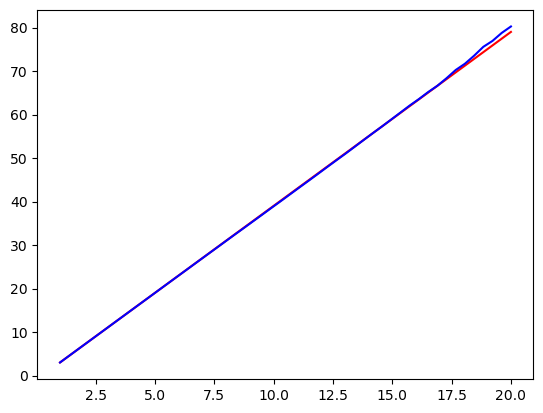

In [50]:
plt.plot(xs, y_true, color='red')
plt.plot(xs, y_pred[0,:], color='blue')

In [2]:
def afterglow(time, redshift,  thv, loge0 , thc, logn0, p, logepse, logepsb, ksin, g0, frequency):
    ag_fluxd = redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, av=0.5,
        base_model='tophat', output_format='flux_density', redshift=redshift,  thv=thv, loge0=loge0 , thc=thc, logn0=logn0, p=p, logepse=logepse,
        logepsb=logepsb, ksin=ksin, g0=g0, frequency= frequency)
    return ag_fluxd


In [3]:
def afterglow_constraints(parameters):
    constrained_params= parameters.copy()
    
    time=np.linspace(0.1,300,300) #make sure time arrays match
    maxflux=[]
    peaktime=[]
    minflux=[]
    for i in range(len(parameters['thv'])):
        flux= redback.transient_models.extinction_models.extinction_with_afterglow_base_model(time=time, redshift=0.01, av=0.5,
            base_model='tophat',  thv= parameters['thv'][i], loge0=parameters['loge0'][i] , thc=parameters['thc'][i], logn0=parameters['logn0'][i], 
            p=2.3, logepse=-1.25, logepsb=-2.5, ksin=1.0, g0=1000,
            output_format='flux_density', frequency=1146839759677006.2)
        maxflux.append(max(flux))
        peaktime.append(time[np.argmax(flux)])
        fluxday1= np.interp(1,time,flux)
        minflux.append(fluxday1)
        
    #peak flux must be at times < 200 days
    constrained_params['peak_time']= 200 - np.array(peaktime)
    #peak flux must be greater than 10e-12
    constrained_params['max_flux']= np.array(maxflux) - (10e-12)
    #thv must be greater than thc
    constrained_params['valid_jet']= parameters['thv'] - parameters['thc']
    #filter on axis results (comment out if needed)
    #constrained_params['onaxis']= 0.05 - parameters['thv']
    #filter lower flux afterglows out for ON AXIS case (comment out if needed)
    #constrained_params['min_flux']= np.array(minflux) - 10e-7
    #filter off axis results (comment out if needed)
    constrained_params['offaxis']= parameters['thv'] - 0.06
    return constrained_params

In [215]:
priors = PriorDict(conversion_function=afterglow_constraints)
priors['max_flux']= Constraint(minimum=0, maximum=20)
priors['peak_time']= Constraint(minimum=0, maximum=250)
#priors['onaxis']= Constraint(minimum=0, maximum=0.05)
#priors['min_flux']=Constraint(minimum=0, maximum=10)
priors['offaxis']= Constraint(minimum=0.06, maximum=(np.pi)/2)
priors.update(redback.priors.get_priors(model='tophat'))
priors['p']=  2.3
priors['loge0']= Uniform(minimum=46, maximum=53, name='loge0', latex_label='$\\log_{10}E_{0}$', unit=None, boundary=None)
priors['redshift']= 0.01
priors['logepse']= -1.25
priors['logepsb']= -2.5
priors['ksin']= 1.0
priors['g0']= 1000
priors['frequency']= Uniform(minimum=5e9, maximum=2e17, name='frequency', latex_label='$frequency$', unit=None, boundary=None)

num=10000
samples=priors.sample(num)
afterglow_data=pd.DataFrame.from_dict(samples)

In [269]:
time = np.linspace(0.1, 300, 600) #xs
yvals = np.zeros((num, len(time)))  #ys

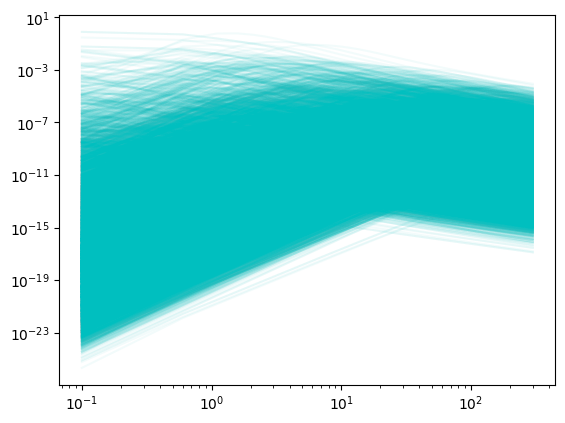

In [270]:
ax= plt.subplot()

for i in range(num):
    yvals[i]= afterglow(time, **afterglow_data.iloc[i])
    ax.loglog(time, yvals[i], color='c', alpha=0.05)
plt.show()

In [290]:
X = afterglow_data.values
Y = yvals
regr = MLPRegressor(random_state=7, max_iter=7000, hidden_layer_sizes=(200,),activation='logistic',solver='sgd', learning_rate='adaptive').fit(X, Y)

In [291]:
params=np.array([0.01, 0.5, 50.0 , 0.02, 1, 2.13,-1.25, -2.5, 1, 1000, 4e14])
prediction = regr.predict(params.reshape(1,-1))
prediction.shape

(1, 600)

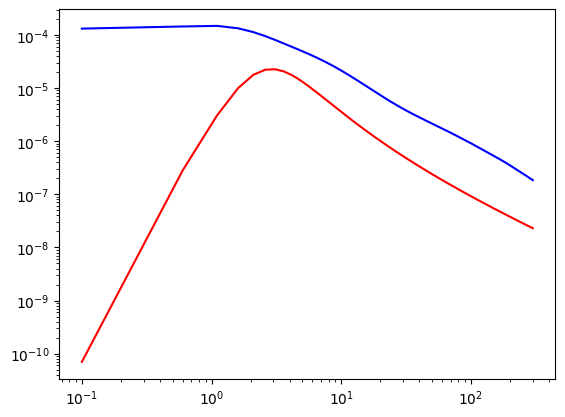

In [292]:
test_params= dict(redshift=0.01,  thv= 0.5, loge0=50.0 , thc= 0.02, logn0=1, p=2.13, logepse=-1.25, logepsb=-2.5, ksin=1, g0=1000,
     frequency= 4e14)
true_value= afterglow(time, **test_params)
ax1=plt.subplot()
ax1.loglog(time, true_value, color='red')
ax1.loglog(time, prediction[0,:], color='blue')#, ls='None', marker='x')
plt.show()

In [207]:
def tophat_func(time,  thv, loge0 , thc, logn0, p, logepse, logepsb, g0):
    flux= tophat(time=time, output_format='flux_density', redshift=0.01,  thv=thv, loge0=loge0 , thc=thc, logn0=logn0, p=p, logepse=logepse,
        logepsb=logepsb, ksin=1, g0=g0, frequency= 2e17)
    return flux

In [3]:
general_priors= redback.priors.get_priors(model='tophat')
#['frequency']= Uniform(minimum=5e9, maximum=2e17, name='frequency', latex_label='$frequency$', unit=None, boundary=None)
general_priors

num=10000
samples=general_priors.sample(num)
tophat_data=pd.DataFrame.from_dict(samples)
tophat_data.drop('redshift', axis=1,inplace=True)
tophat_data.drop('ksin', axis=1,inplace=True)
tophat_data

,thv,loge0,thc,logn0,p,logepse,logepsb,g0
0,1.461343,51.060150,0.092228,-4.060344,2.869274,-4.988613,-2.390040,353.014562
1,1.004462,46.195276,0.092931,-1.522481,2.789801,-2.846018,-2.587321,968.959327
2,1.524765,49.530547,0.024272,-1.902860,2.729761,-3.832385,-1.352724,705.587963
3,1.238723,50.414081,0.067677,-2.863839,2.868433,-2.362634,-2.390234,1665.874391
4,0.233016,44.653639,0.047583,-1.411141,2.657581,-0.380973,-3.564416,1353.943186
...,...,...,...,...,...,...,...,...
9995,1.204385,50.265331,0.012955,-2.831604,2.470313,-1.165247,-1.030829,397.937294
9996,1.255790,48.222364,0.078329,-0.697949,2.455154,-4.470265,-4.261774,164.215852
9997,1.444405,51.532130,0.067509,-2.881713,2.269805,-4.914761,-0.828631,249.776123
9998,1.231419,53.230843,0.091603,-2.866371,2.788872,-4.157320,-0.196018,1118.224997


In [213]:
training = tophat_data.iloc[:9900]
testing = tophat_data.iloc[9900:]

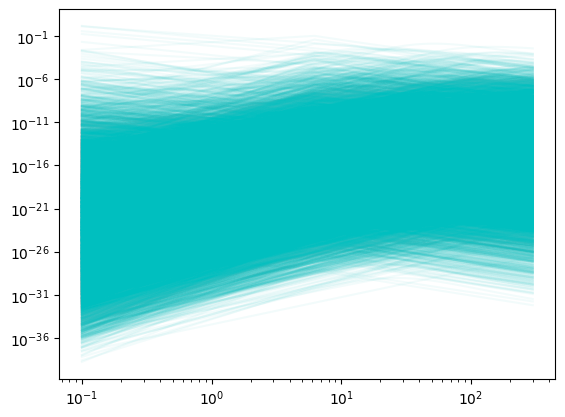

In [237]:
time = np.linspace(0.1, 300, 50) #xs
ys = np.zeros((9900, len(time)))  #ys

ax= plt.subplot()

for i in range(9900):
    ys[i]= tophat_func(time, **training.iloc[i])
    ax.loglog(time, ys[i], color='c', alpha=0.05)
plt.show()

In [259]:
scaler = pre.StandardScaler()
Y_train = scaler.fit_transform(np.log10(ys))
X_train = training.values 
#xscale=scaler.fit(X_train)
#X_train= xscale.transform(X_train)
X_test= (testing.values)
regr = MLPRegressor(random_state=7, max_iter=7000, hidden_layer_sizes=(200,),activation='logistic',solver='adam',learning_rate='adaptive',
                   learning_rate_init=1e-4).fit(X_train, Y_train)
#params=np.array([0.5, 50.0 , 0.02, 1, 2.13,-1.25,-2.5, 1000])
#prediction = regr.predict(params.reshape(1,-1))


In [260]:
prediction = regr.predict(X_test)
prediction = 10**(scaler.inverse_transform(prediction))
prediction.shape

(100, 50)

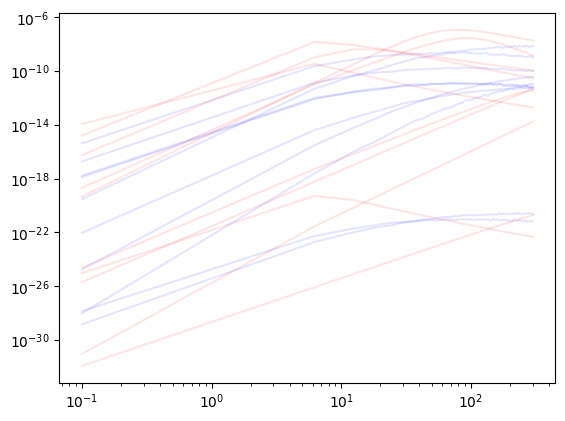

In [261]:
time = np.linspace(0.1, 300, 50) #xs
#test_params= dict(thv= 0.5, loge0=50.0 , thc= 0.02, logn0=1, p=2.13, logepse=-1.25, logepsb=-2.5, g0=1000)
ax1=plt.subplot()
for i in range(10): 
    true_value= tophat_func(time, **testing.iloc[i])
    ax1.loglog(time, true_value, color='red', alpha=0.1)
    ax1.loglog(time, prediction[i], color='blue', alpha=0.1)# ls='None', marker='x')
    #print(regr.score(testing.values[i].reshape(1,-1),true_value.reshape(1,-1)))
plt.show()

In [223]:
X_test.shape

(100, 8)

In [47]:
ys.shape

(10000, 600)

In [24]:
training.values

array([[ 1.46134341e+00,  5.10601498e+01,  9.22281176e-02, ...,
        -4.98861347e+00, -2.39003999e+00,  3.53014562e+02],
       [ 1.00446150e+00,  4.61952763e+01,  9.29308726e-02, ...,
        -2.84601763e+00, -2.58732105e+00,  9.68959327e+02],
       [ 1.52476536e+00,  4.95305475e+01,  2.42721474e-02, ...,
        -3.83238500e+00, -1.35272363e+00,  7.05587963e+02],
       ...,
       [ 5.09738796e-01,  5.34748385e+01,  2.33128056e-02, ...,
        -3.65525096e+00, -2.84812452e+00,  3.69286549e+02],
       [ 1.27232820e+00,  4.79354545e+01,  1.86686853e-02, ...,
        -4.87834324e+00, -3.49603099e+00,  3.77666606e+02],
       [ 1.54673474e+00,  4.99889743e+01,  7.80024536e-02, ...,
        -4.96281044e+00, -4.37828399e-01,  7.67830068e+02]])

In [248]:
prediction

array([[7.62265210e-30, 5.36443717e-24, 2.97581616e-23, ...,
        3.42394475e-22, 3.72356480e-22, 3.48034714e-22],
       [1.45857945e-16, 9.26055232e-11, 2.90259504e-10, ...,
        4.10541123e-10, 3.88216372e-10, 4.30230841e-10],
       [6.42576632e-18, 1.16417013e-12, 3.77348318e-12, ...,
        2.92480328e-12, 2.53486746e-12, 2.76983602e-12],
       ...,
       [5.03103293e-33, 8.41129864e-23, 2.44145484e-21, ...,
        1.73520500e-16, 1.93369330e-16, 2.01522684e-16],
       [1.57229677e-30, 3.04149923e-21, 6.98237961e-20, ...,
        7.82969301e-16, 9.96169233e-16, 8.27008929e-16],
       [8.45768746e-34, 4.57165655e-23, 2.58417060e-21, ...,
        1.14378653e-15, 1.61903273e-15, 1.27417597e-15]])

In [76]:
def power(frequency, g0, logepsb, logn0):
    me= const.m_e
    mp= const.m_p
    c= const.c
    sigma = const.sigma
    q=const.e
    n0= 10**(logn0)
    epsb= 10**(logepsb)
    constant = (me*(c**3)*sigma*((32*np.pi*mp)**0.5))/(3*q)

    pow= constant*(g0**2)*((epsb*n0)**0.5)*frequency*10e7 #power in ergs
    return pow

In [77]:
pprior = bilby.core.prior.PriorDict()
pprior['g0'] = bilby.core.prior.Uniform(100, 2000, 'g0')
pprior['logepsb'] = bilby.core.prior.Uniform(-5, 0, 'c')
pprior['logn0']=bilby.core.prior.Uniform(-5,2,'logn0')
pprior

{'g0': Uniform(minimum=100, maximum=2000, name='g0', latex_label='g0', unit=None, boundary=None),
 'logepsb': Uniform(minimum=-5, maximum=0, name='c', latex_label='c', unit=None, boundary=None),
 'logn0': Uniform(minimum=-5, maximum=2, name='logn0', latex_label='logn0', unit=None, boundary=None)}

In [78]:
N= 5000
samples=pprior.sample(N)
power_data=pd.DataFrame.from_dict(samples)
power_data

,g0,logepsb,logn0
0,185.380307,-2.711978,0.601665
1,1423.031101,-4.650265,1.992532
2,394.884171,-0.541732,-1.991962
3,1221.158402,-4.845642,1.404221
4,415.062706,-3.860507,-4.259996
...,...,...,...
4995,944.116862,-2.469384,-2.699051
4996,1360.925225,-1.993366,0.738621
4997,959.389273,-3.519324,1.084934
4998,797.601144,-0.752727,-0.088104


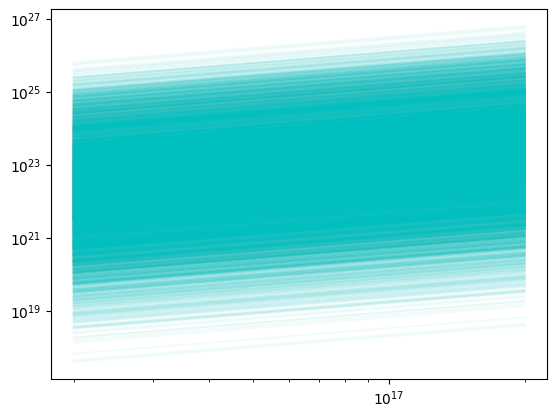

In [188]:
frequency = np.linspace(2e16, 2e17, 500) #xs
y = np.zeros((4900, len(frequency)))  #ys  

ax= plt.subplot()
for i in range(4900):
    y[i]= power(frequency, **power_data.iloc[i])
    ax.loglog(frequency, y[i], color='c', alpha=0.05)
plt.show()

In [196]:
y_train= y
scaler = pre.StandardScaler()
x_train=power_data.iloc[:4900].values
scaler.fit(x_train)  
x_train = scaler.transform(x_train) 

x_test=power_data.iloc[4900:].values
x_test = scaler.transform(x_test)

regress = MLPRegressor(random_state=7, max_iter=2000, hidden_layer_sizes=(100,), activation='tanh',solver='sgd',learning_rate='adaptive', 
                       learning_rate_init=1e-5, batch_size= 16).fit(x_train, y_train)

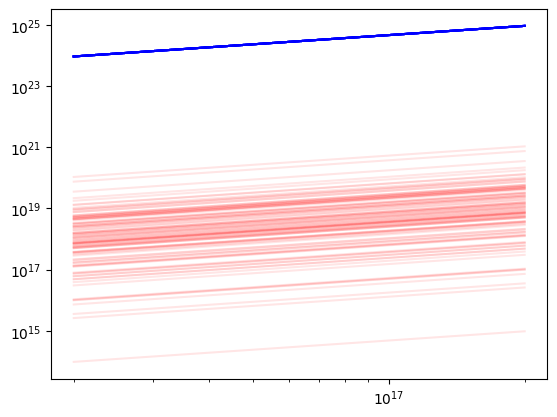

In [197]:
prediction = regress.predict(x_test)
#print(prediction)
#test_params= dict(thv= 0.5, loge0=50.0 , thc= 0.02, logn0=1, p=2.13, logepse=-1.25, logepsb=-2.5, g0=1000)
ax2=plt.subplot()
for i in range(100): 
    true_value= power(frequency, *x_test[i])
    ax2.loglog(frequency, true_value, color='red', alpha=0.1)
    ax2.loglog(frequency, prediction[i], color='blue', alpha=0.1)# ls='None', marker='x')
    #print(regr.score(testing.values[i].reshape(1,-1),true_value.reshape(1,-1)))
#plt.ylim(10e22,10e25)
plt.show()